In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import spacy
from spacy import displacy

nlp = spacy.load("en_core_web_sm")

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import sklearn.base as skb
import sklearn.metrics as skm
import sklearn.model_selection as skms
import sklearn.preprocessing as skp
import sklearn.linear_model as sklm
import warnings
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from xgboost import XGBClassifier
import joblib
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import OrderedDict
warnings.filterwarnings('ignore')
import random
from nltk.corpus import wordnet
seed = 5
np.random.seed(seed)

sns.set_style('whitegrid')
plt.style.use('seaborn-v0_8-deep')
plt.style.use('fivethirtyeight')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.monospace'] = 'Ubunto Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.titlesize'] = 14
plt.rcParams['figure.figsize'] = (12,8)

In [ ]:
#SENTIMENT_ANALYSIS_PART

In [ ]:
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN



def clean_text(text):
    text = text.lower()  # Convert text to lowercase
    text = [word.strip(string.punctuation) for word in text.split(" ")]  # Tokenize and remove punctuation
    text = [word for word in text if not any(c.isdigit() for c in word)]  # Remove words with numbers
    stop = stopwords.words('english')  # Define stopwords
    text = [x for x in text if x not in stop]  # Remove stopwords
    pos_tags = pos_tag(text)  # POS tagging
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]  # Lemmatization
    text = [t for t in text if len(t) > 1]  # Remove words with only one letter
    return " ".join(text)

def sentiment_feedback(sentiment_df, doc2vec_model, tfidf_vectorizer, xgb):

    sentiment_df.dropna()
    sentiment_df.mask(sentiment_df.eq('None')).dropna()
    sentiment_df.mask(sentiment_df.astype(object).eq('None')).dropna()
    sentiment_df = sentiment_df.replace(to_replace='None', value=np.nan).dropna()
    sentiment_df = sentiment_df.rename(columns={"content": "review"})

    sentiment_df["review_clean"] = sentiment_df["review"].apply(lambda x: clean_text(x))
    sentiment_df["summary_clean"] = sentiment_df["summary"].apply(lambda x: clean_text(x))

    sid = SentimentIntensityAnalyzer()
    sentiment_df["sentiments"] = sentiment_df["review"].apply(lambda x: sid.polarity_scores(x))
    sentiment_df = pd.concat([sentiment_df.drop(['sentiments'], axis=1), sentiment_df['sentiments'].apply(pd.Series)], axis=1)
    sentiment_df = sentiment_df.rename(columns={"neg": "neg_rw", "neu": "neu_rw","pos": "pos_rw", "compound": "compound_rw"})

    sentiment_df["sentiments_sm"] = sentiment_df["summary"].apply(lambda x: sid.polarity_scores(x))
    sentiment_df = pd.concat([sentiment_df.drop(['sentiments_sm'], axis=1), sentiment_df['sentiments_sm'].apply(pd.Series)], axis=1)
    sentiment_df = sentiment_df.rename(columns={"neg": "neg_sm", "neu": "neu_sm","pos": "pos_sm", "compound": "compound_sm"})
    sentiment_df = sentiment_df.rename(columns={"neg_rw": "neg", "neu_rw": "neu","pos_rw": "pos", "compound_rw": "compound"})

    # add number of characters column
    sentiment_df["nb_chars"] = sentiment_df["review"].apply(lambda x: len(x))
    sentiment_df["nb_chars_sm"] = sentiment_df["summary"].apply(lambda x: len(x))

    # add number of words column
    sentiment_df["nb_words"] = sentiment_df["review"].apply(lambda x: len(x.split(" ")))
    sentiment_df["nb_words_sm"] = sentiment_df["summary"].apply(lambda x: len(x.split(" ")))

    # transform each document into a vector data

    doc2vec_df = sentiment_df["review_clean"].apply(lambda x: doc2vec_model.infer_vector(x.split(" "))).apply(pd.Series)
    doc2vec_df.columns = ["doc2vec_rw_vector_" + str(x) for x in doc2vec_df.columns]
    sentiment_df = pd.concat([sentiment_df, doc2vec_df], axis=1)
    doc2vec_df_sm = sentiment_df["summary_clean"].apply(lambda x: doc2vec_model.infer_vector(x.split(" "))).apply(pd.Series)
    doc2vec_df_sm.columns = ["doc2vec_sm_vector_" + str(x) for x in doc2vec_df_sm.columns]
    sentiment_df = pd.concat([sentiment_df, doc2vec_df_sm], axis=1)


    merge_clean = sentiment_df[["review_clean", "summary_clean"]].apply(lambda x: " ".join(x), axis=1)
    merge_clean = merge_clean.apply(lambda x: list(OrderedDict.fromkeys(x.split(" "))))
    merge_clean = merge_clean.apply(lambda x: " ".join(x))

    tfidf_result = tfidf_vectorizer.transform(merge_clean).toarray()
    tfidf_df = pd.DataFrame(tfidf_result, columns=tfidf_vectorizer.get_feature_names_out())
    tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
    tfidf_df.index = sentiment_df.index
    sentiment_df = pd.concat([sentiment_df, tfidf_df], axis=1)

    sentiment_df = sentiment_df.loc[:, ~sentiment_df.columns.duplicated()].copy()

    ignore_cols = ["review", "review_clean", "summary",'summary_clean']
    features = [c for c in sentiment_df.columns if c not in ignore_cols]

    X_test = sentiment_df[features]

    y_pred_list = xgb.predict_proba(X_test)
    y_pred = [np.max(x) for x in y_pred_list]
    y_pred_f = xgb.predict(X_test)
    y_pred_f = list(y_pred_f)
    output_df = pd.DataFrame(list(zip(y_pred_f, y_pred)), columns=['sentiment','sent_score'])

    return output_df


CHURN PREDICTION PART

In [ ]:
# --- Load NLP models ---
doc2vec_model = Doc2Vec.load('/content/drive/MyDrive/churn_prediction/models/sentimenta_doc2vec_model')
tfidf_vectorizer = joblib.load('/content/drive/MyDrive/churn_prediction/models/sentimenta_tfidf_model')
xgb_model = joblib.load('/content/drive/MyDrive/churn_prediction/models/sentimenta_xgb_model.pkl')


In [ ]:

# --- Load data ---
df = pd.read_csv('/content/drive/MyDrive/churn_prediction/data/customers/churn_train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/churn_prediction/data/customers/churn_test.csv')
df = df.rename(columns={"churn_score": "churn_risk_score", 'content': 'feedback'})
df_test = df_test.rename(columns={'content':'feedback'})
df['region_category'] = df['region_category'].fillna('Other')
df_test['region_category'] = df_test['region_category'].fillna('Other')
df['avg_transaction_value'] *= 0.01
df_test['avg_transaction_value'] = df_test['avg_transaction_value'].apply(lambda x: x*0.01)# Scale transaction value for better analysis


In [ ]:
# --- Preprocess sentiment data ---

to_sentiment_df = pd.DataFrame(df[['feedback','summary']], columns=['feedback','summary'])
to_sentiment_df = to_sentiment_df.rename(columns={'feedback':'content'})
to_sentiment_df_test = pd.DataFrame(df_test[['feedback','summary']], columns=['feedback','summary'])
to_sentiment_df_test = to_sentiment_df_test.rename(columns={'feedback':'content'})

output_sentiment_df = sentiment_feedback(to_sentiment_df, doc2vec_model, tfidf_vectorizer, xgb_model)
output_sentiment_df_test = sentiment_feedback(to_sentiment_df_test, doc2vec_model, tfidf_vectorizer, xgb_model)


output_sentiment_df.index = df.index
output_sentiment_df_test.index = df_test.index
df = pd.concat([df,output_sentiment_df], axis=1)
df_test = pd.concat([df_test,output_sentiment_df_test], axis=1)

df=df.drop('Unnamed: 0', axis=1)
df_test=df_test.drop('Unnamed: 0', axis=1)
df_test=df_test.drop('sentiments', axis=1)


In [ ]:
targetFeature = 'churn_risk_score'

In [ ]:
# --- Separate numerical and categorical features ---
def divide_features(df):
    """Separates numerical and categorical features."""
    numerical_features = df.select_dtypes(include=[np.number])
    categorical_features = df.select_dtypes(include=[object])
    return numerical_features, categorical_features

num_features, cat_features = divide_features(df)

In [ ]:
df.drop(['customer_id','Name','security_no','referral_id'],axis=1,inplace=True)
df_test.drop(['customer_id','Name','security_no','referral_id'],axis=1,inplace=True)

In [ ]:
num_feature, cat_feature = divide_features(df)

In [ ]:
cat_feature['avg_frequency_login_days'].replace(['Error'],np.nan,inplace=True)

In [ ]:
arr = cat_feature['avg_frequency_login_days'].unique()

<Axes: >

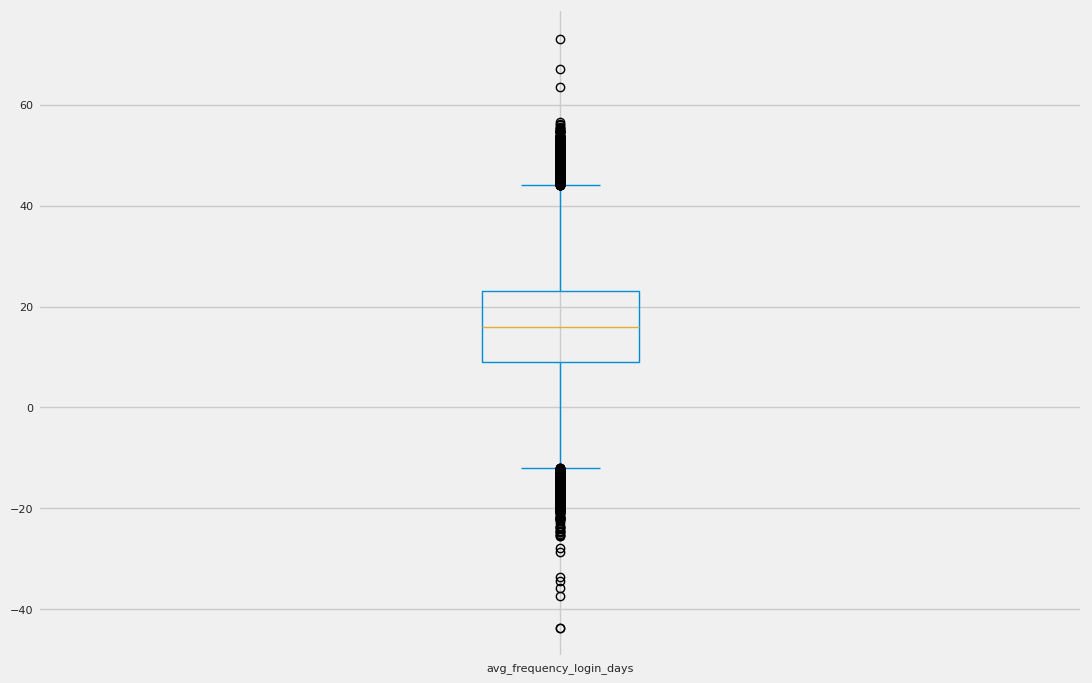

In [ ]:
cat_feature['avg_frequency_login_days'].astype('float64').plot(kind='box')

In [ ]:
df['avg_frequency_login_days'].replace(['Error'],np.nan,inplace=True)
df_test['avg_frequency_login_days'].replace(['Error'],np.nan,inplace=True)

In [ ]:
df['avg_frequency_login_days'] = df['avg_frequency_login_days'].astype('float64')
df_test['avg_frequency_login_days'] = df_test['avg_frequency_login_days'].astype('float64')

In [ ]:
num_feature,cat_feature = divide_features(df)

In [ ]:
skewed_features = num_feature.apply(lambda x:x.skew()).sort_values(ascending=False)

In [ ]:
# Dropping all rows whose 'avg_time_spent' is negative
low = df['avg_time_spent'] < 0
low = np.where(low)
df.drop(low[0],inplace=True)

In [ ]:
df.isnull().sum()

,0
age,0
gender,0
region_category,0
membership_category,0
joining_date,0
joined_through_referral,0
preferred_offer_types,273
medium_of_operation,0
internet_option,0
last_visit_time,0


In [ ]:
# Reseting the default index
df.index = range(0,df.shape[0])

In [ ]:
# Dropping all rows whose 'points_in_wallet' is negative
l1 = np.where(df['points_in_wallet'] < 0)
df.drop(l1[0],inplace=True)
df.index = range(0,df.shape[0])

In [ ]:
# Dropping all rows whose 'avg_frequency_login_days' is negative
l2 = np.where(df['avg_frequency_login_days'] < 0)
df.drop(l2[0],inplace=True)
df.index = range(0,df.shape[0])

In [ ]:
# Dropping all rows whose 'avg_transaction_value' is negative
l3 = np.where(df['avg_transaction_value'] < 0)
df.drop(l3[0],inplace=True)
df.index = range(0,df.shape[0])

In [ ]:
# Dropping all rows whose 'days_since_last_login' is negative
l4 = np.where(df['days_since_last_login'] < 0)
df.drop(l4[0],inplace=True)
df.index = range(0,df.shape[0])

In [ ]:
df.dropna(how='any',inplace=True)

In [ ]:
df['joining_date'] = pd.to_datetime(df['joining_date'])
df['last_visit_time'] = pd.to_datetime(df['last_visit_time'])

df_test['joining_date'] = pd.to_datetime(df_test['joining_date'])
df_test['last_visit_time'] = pd.to_datetime(df_test['last_visit_time'])

In [ ]:
df['jday'] = df['joining_date'].dt.day
df_test['jday'] = df_test['joining_date'].dt.day

In [ ]:
df['jday'] = df['joining_date'].dt.day
df['jmonth'] = df['joining_date'].dt.month
df['jweek'] = df['joining_date'].dt.dayofweek
df_test['jday'] = df_test['joining_date'].dt.day
df_test['jmonth'] = df_test['joining_date'].dt.month
df_test['jweek'] = df_test['joining_date'].dt.dayofweek

In [ ]:
df['diff'] =  ((df['last_visit_time'] - df['joining_date']).apply(lambda x:str(x).split()[0])).astype('float64')
df_test['diff'] =  ((df_test['last_visit_time'] - df_test['joining_date']).apply(lambda x:str(x).split()[0])).astype('float64')

In [ ]:
# Clearly target labels are imbalanced. So we'll use Over sampling techinques
df['churn_risk_score'].value_counts()

,count
churn_risk_score,
3,7514
4,7277
5,6999
2,1958
1,1920
-1,837


In [ ]:
df.index = range(0,df.shape[0])

# Removing all the rows having 'churn_risk_score' == -1
l5 = np.where(df['churn_risk_score'] == -1)
df.drop(l5[0],inplace=True)
df.index = range(0,df.shape[0])

In [ ]:
# Selecting categorical features into a new dataframe
sm = ['gender','region_category','membership_category','joined_through_referral',
      'preferred_offer_types','medium_of_operation','internet_option','used_special_discount',
       'offer_application_preference']
df_sm = df[sm]
df_test_sm = df_test[sm]
print(df_test_sm.shape)

(19915, 9)


In [ ]:
# Creating dummies for categorical feature columns
df_sm = pd.get_dummies(df_sm)
df_test_sm = pd.get_dummies(df_test_sm)
print(df_test_sm.shape)

(19915, 30)


In [ ]:
# Selecting Numerical features into a new dataframe

ss = ['days_since_last_login','avg_time_spent','avg_transaction_value','avg_frequency_login_days',
'points_in_wallet','used_special_discount','sentiment','sent_score','churn_risk_score','jday','jmonth','jweek','diff']
df_ss = df[ss]
ss_t = ['days_since_last_login','avg_time_spent','avg_transaction_value','avg_frequency_login_days',
'points_in_wallet','used_special_discount','sentiment','sent_score','jday','jmonth','jweek','diff']
df_test_ss = df_test[ss_t]
print(df_test_ss.shape)

(19915, 12)


In [ ]:
# Concatenating the dummy columns and numerical feature columns into a new dataframe
df_new = pd.concat([df_ss,df_sm],axis=1)
df_test_new = pd.concat([df_test_ss,df_test_sm],axis=1)

In [ ]:
df_new.drop(['used_special_discount'],axis=1,inplace=True)
df_test_new.drop(['used_special_discount'],axis=1,inplace=True)

In [ ]:
df_test_new['avg_frequency_login_days'].fillna(value=df_test_new['avg_frequency_login_days'].mean(),inplace=True)
df_test_new['points_in_wallet'].fillna(value=df_test_new['points_in_wallet'].mean(),inplace=True)


In [ ]:
df_test.shape

(19915, 25)

In [ ]:
df_new.dropna(axis=0,how='any',inplace=True)

In [ ]:
X = df_new.drop(['churn_risk_score'],axis=1).values
Y = df_new['churn_risk_score'].values

In [ ]:
# Applying SMOTE Over Sampling Strategy
from imblearn.over_sampling import SMOTE
oversampler = SMOTE()
X_ov,Y_ov = oversampler.fit_resample(X,Y)
print('The dataset before oversampling: ',X.shape,Y.shape)
print('The dataset after oversampling: ',X_ov.shape,Y_ov.shape)

The dataset before oversampling:  (25668, 41) (25668,)
The dataset after oversampling:  (37570, 41) (37570,)


In [ ]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X_ov = scaler.fit_transform(X_ov)
X_test = df_test_new.values
X_test = scaler.transform(X_test)

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(X_ov,Y_ov,train_size=0.7)

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix,f1_score

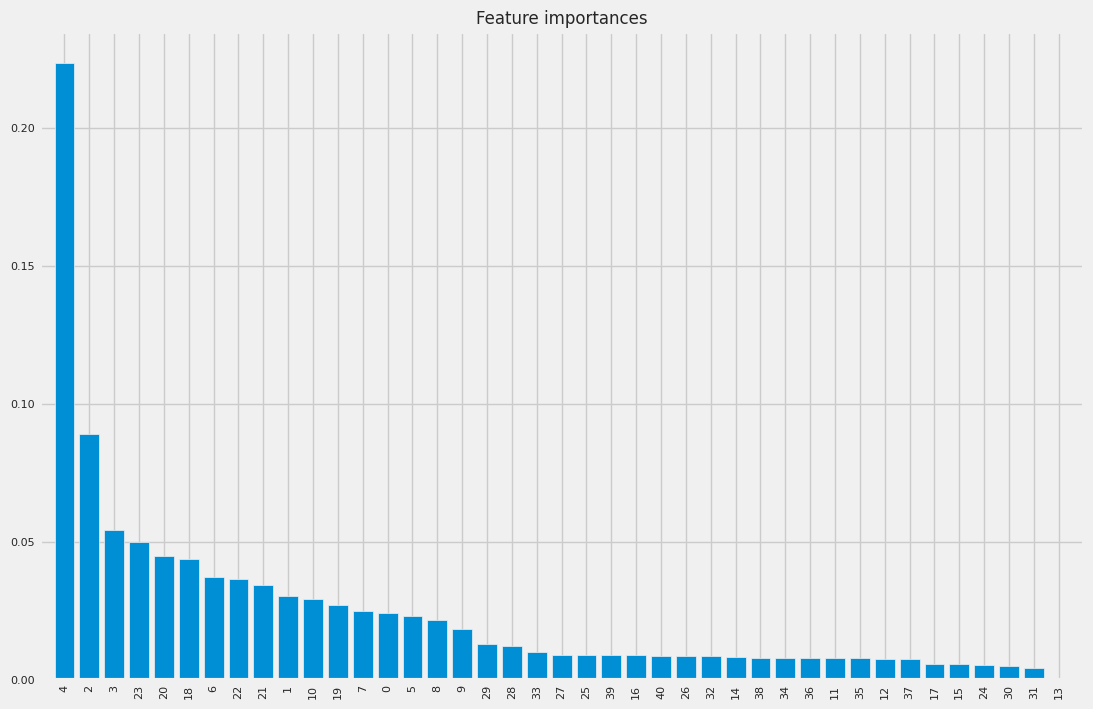

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix,f1_score
rf = RandomForestClassifier(n_estimators=1000,max_depth=25)
rf.fit(x_train,y_train)
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Візуалізація важливості ознак
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), indices, rotation=90)
plt.xlim([-1, len(importances)])
plt.show()


In [ ]:
# Збережіть назви ознак перед масштабуванням
feature_names = df_new.drop(['churn_risk_score'], axis=1).columns

# Перетворіть x_train та x_test назад у DataFrame з назвами ознак
x_train = pd.DataFrame(x_train, columns=feature_names)
x_test = pd.DataFrame(x_test, columns=feature_names)

In [ ]:
important_features = x_train.columns[indices[:15]]
x_train_reduced = x_train[important_features]
x_test_reduced = x_test[important_features]

rf_reduced = RandomForestClassifier(n_estimators=100, max_depth=10)
rf_reduced.fit(x_train_reduced, y_train)
y_pred_reduced = rf_reduced.predict(x_test_reduced)
print(classification_report(y_true=y_test, y_pred=y_pred_reduced))
print(f1_score(y_true=y_test, y_pred=y_pred_reduced, average='macro'))

              precision    recall  f1-score   support

           1       0.81      0.85      0.83      2249
           2       0.93      0.67      0.78      2224
           3       0.72      0.91      0.81      2304
           4       0.74      0.77      0.75      2237
           5       0.87      0.79      0.83      2257

    accuracy                           0.80     11271
   macro avg       0.81      0.80      0.80     11271
weighted avg       0.81      0.80      0.80     11271

0.7983164961356344


In [ ]:
y_pred = rf.predict(x_test)
print(classification_report(y_true=y_test,y_pred=y_pred))
print(f1_score(y_true=y_test,y_pred=y_pred,average='macro'))

              precision    recall  f1-score   support

           1       0.90      0.89      0.90      2249
           2       0.95      0.80      0.87      2224
           3       0.78      0.93      0.85      2304
           4       0.74      0.74      0.74      2237
           5       0.84      0.81      0.83      2257

    accuracy                           0.84     11271
   macro avg       0.84      0.84      0.84     11271
weighted avg       0.84      0.84      0.84     11271

0.8366993254315191


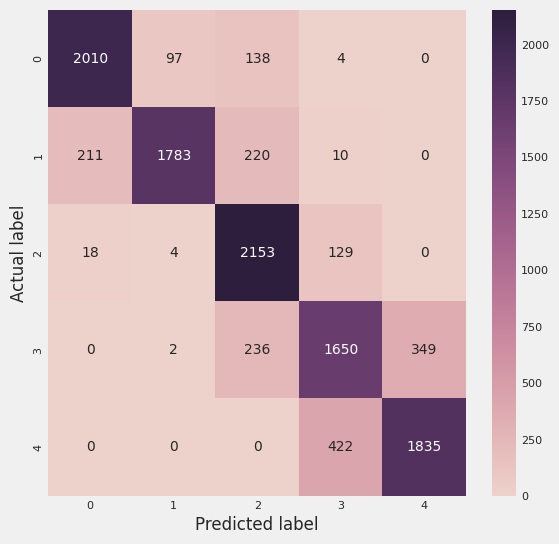

In [ ]:
fig = plt.figure(figsize=(6, 6))
ax= plt.subplot()
cm = confusion_matrix(y_true=y_test,y_pred=y_pred)
# cm = confusion_matrix(y_true=y_test,y_pred=y_pred_reduced)
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g', cmap = sns.cubehelix_palette(as_cmap=True))
ax.set_xlabel('Predicted label')
ax.set_ylabel('Actual label')
plt.show()

In [ ]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(100,100,100))
mlp.fit(x_train,y_train)
y_pred = mlp.predict(x_test)
print(classification_report(y_true=y_test,y_pred=y_pred))
print(f1_score(y_true=y_test,y_pred=y_pred,average='macro'))

              precision    recall  f1-score   support

           1       0.88      0.89      0.88      2249
           2       0.83      0.85      0.84      2224
           3       0.78      0.76      0.77      2304
           4       0.69      0.69      0.69      2237
           5       0.79      0.79      0.79      2257

    accuracy                           0.79     11271
   macro avg       0.79      0.79      0.79     11271
weighted avg       0.79      0.79      0.79     11271

0.7944055608345071


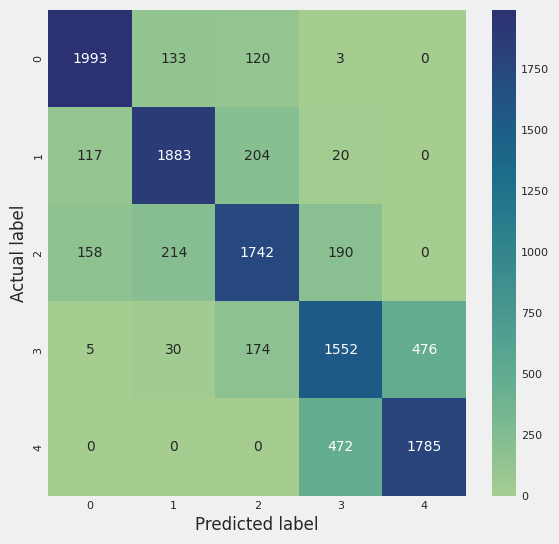

In [ ]:
fig = plt.figure(figsize=(6, 6))
ax= plt.subplot()
cm = confusion_matrix(y_true=y_test,y_pred=y_pred)
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g', cmap = 'crest')
ax.set_xlabel('Predicted label')
ax.set_ylabel('Actual label')
plt.show()

In [ ]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(criterion='entropy',max_depth=15, min_samples_split=10, min_samples_leaf=12)
tree.fit(x_train,y_train)
y_pred = tree.predict(x_test)
print(classification_report(y_true=y_test,y_pred=y_pred))
print(f1_score(y_true=y_test,y_pred=y_pred,average='macro'))

              precision    recall  f1-score   support

           1       0.82      0.83      0.83      2249
           2       0.82      0.73      0.77      2224
           3       0.78      0.86      0.81      2304
           4       0.71      0.78      0.75      2237
           5       0.85      0.76      0.80      2257

    accuracy                           0.79     11271
   macro avg       0.80      0.79      0.79     11271
weighted avg       0.80      0.79      0.79     11271

0.7928803978829169


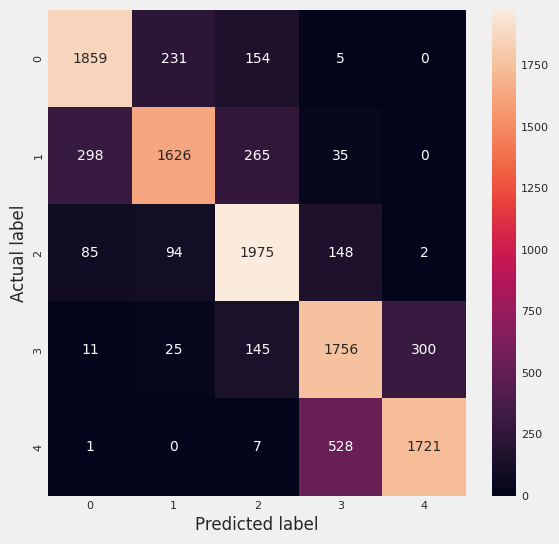

In [ ]:
fig = plt.figure(figsize=(6, 6))
ax= plt.subplot()
cm = confusion_matrix(y_true=y_test,y_pred=y_pred)
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g')
ax.set_xlabel('Predicted label')
ax.set_ylabel('Actual label')
plt.show()

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gbrt = GradientBoostingClassifier(n_estimators=100,max_depth=10,min_samples_leaf = 4, min_samples_split= 5)
gbrt.fit(x_train,y_train)
y_pred = gbrt.predict(x_test)
print(classification_report(y_true=y_test,y_pred=y_pred))
print(f1_score(y_true=y_test,y_pred=y_pred,average='macro'))

              precision    recall  f1-score   support

           1       0.93      0.91      0.92      2249
           2       0.94      0.83      0.89      2224
           3       0.82      0.91      0.86      2304
           4       0.73      0.78      0.75      2237
           5       0.84      0.81      0.82      2257

    accuracy                           0.85     11271
   macro avg       0.85      0.85      0.85     11271
weighted avg       0.85      0.85      0.85     11271

0.8484428253157497


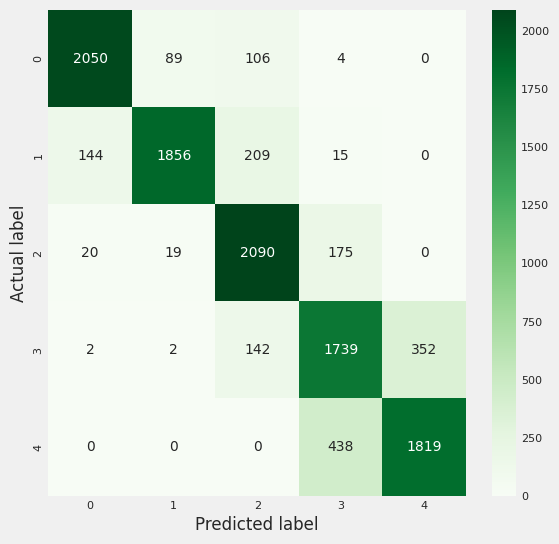

In [ ]:
fig = plt.figure(figsize=(6, 6))
ax= plt.subplot()
cm = confusion_matrix(y_true=y_test,y_pred=y_pred)
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g', cmap = 'Greens')
ax.set_xlabel('Predicted label')
ax.set_ylabel('Actual label')
plt.show()

In [ ]:
from xgboost import XGBClassifier
xgb_churn = XGBClassifier(n_jobs=-1,n_estimators=1000,max_depth=10)
y_train_adjusted  = y_train - 1
xgb_churn.fit(x_train,y_train_adjusted )
y_pred = xgb_churn.predict(x_test)
y_pred_adjusted  = y_pred + 1
print(classification_report(y_true=y_test,y_pred=y_pred_adjusted))
print(f1_score(y_true=y_test,y_pred=y_pred_adjusted ,average='macro'))

              precision    recall  f1-score   support

           1       0.93      0.92      0.93      2249
           2       0.95      0.86      0.90      2224
           3       0.82      0.90      0.86      2304
           4       0.74      0.76      0.75      2237
           5       0.83      0.81      0.82      2257

    accuracy                           0.85     11271
   macro avg       0.86      0.85      0.85     11271
weighted avg       0.86      0.85      0.85     11271

0.8524101907265749


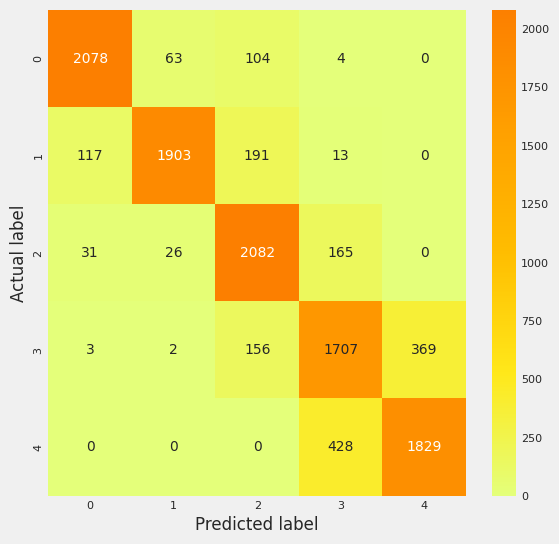

In [ ]:
fig = plt.figure(figsize=(6, 6))
ax= plt.subplot()
cm = confusion_matrix(y_true=y_test,y_pred=y_pred_adjusted)
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g',cmap = 'Wistia')
ax.set_xlabel('Predicted label')
ax.set_ylabel('Actual label')
plt.show()

In [ ]:
# Збереження RandomForestClassifier
joblib.dump(rf, 'random_forest_model.pkl')

# Збереження MLPClassifier
joblib.dump(mlp, 'mlp_classifier_model.pkl')

# Збереження DecisionTreeClassifier
joblib.dump(tree, 'decision_tree_model.pkl')

# Збереження GradientBoostingClassifier
joblib.dump(gbrt, 'gradient_boosting_model.pkl')

# Збереження XGBClassifier
joblib.dump(xgb_churn, 'xgboost_classifier_model.pkl')

['xgboost_classifier_model.pkl']

In [ ]:
class MixModel(skb.BaseEstimator, skb.RegressorMixin, skb.TransformerMixin):

    def __init__(self, algs):
        self.algs = algs

    def fit(self, X, y):
        self.algs_ = [skb.clone(x) for x in self.algs]


        for alg in self.algs_:
            alg.fit(X, y)

        return self


    def predict(self, X):
        predictions = np.column_stack([
            stacked_model.predict(X) for stacked_model in self.algs_
        ])
        return (np.mean(predictions, axis=1)).astype('int64')

In [ ]:
mixed_model = MixModel(algs = [xgb_churn,rf,gbrt])
y_train_adjusted  = y_train - 1
mixed_model.fit(x_train, y_train_adjusted)


MixModel(algs=[XGBClassifier(base_score=None, booster=None, callbacks=None,
                             colsample_bylevel=None, colsample_bynode=None,
                             colsample_bytree=None, device=None,
                             early_stopping_rounds=None,
                             enable_categorical=False, eval_metric=None,
                             feature_types=None, gamma=None, grow_policy=None,
                             importance_type=None, interaction_constraints=None,
                             learning_rate=None, max_bin=None,
                             max_cat_threshold=None, max_cat_to_onehot=None,
                             max_delta_step=None, max_depth=10, max_leaves=None,
                             min_child_weight=None, missing=nan,
                             monotone_constraints=None, multi_strategy=None,
                             n_estimators=1000, n_jobs=-1,
                             num_parallel_tree=None, objective='multi:softprob', ...),
               RandomForestClassifier(max_depth=25, n_estimators=1000),
               GradientBoostingClassifier(max_depth=10, min_samples_leaf=4,
                                          min_samples_split=5)])

In [ ]:
y_pred = mixed_model.predict(x_test)
y_pred_adjusted  = y_pred + 1
print(classification_report(y_true=y_test,y_pred=y_pred_adjusted))
print(f1_score(y_true=y_test,y_pred=y_pred_adjusted,average='macro'))

              precision    recall  f1-score   support

           1       0.89      0.93      0.91      2249
           2       0.93      0.79      0.86      2224
           3       0.79      0.94      0.86      2304
           4       0.73      0.79      0.76      2237
           5       0.90      0.74      0.81      2257

    accuracy                           0.84     11271
   macro avg       0.85      0.84      0.84     11271
weighted avg       0.85      0.84      0.84     11271

0.8395896951860327


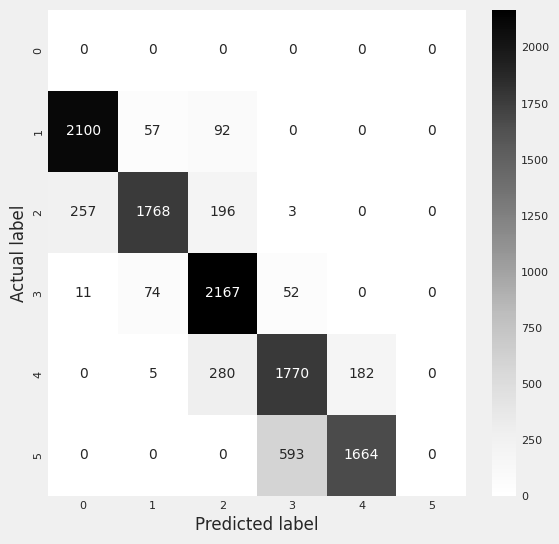

In [ ]:
fig = plt.figure(figsize=(6, 6))
ax= plt.subplot()
cm = confusion_matrix(y_true=y_test,y_pred=y_pred)
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g', cmap = 'Greys')
ax.set_xlabel('Predicted label')
ax.set_ylabel('Actual label')
plt.show()

In [ ]:
# Збереження XGBClassifier
joblib.dump(mixed_model, 'mixed_model.pkl')

['mixed_model.pkl']

In [ ]:
def preload_for_test(curr_df):

  curr_df.drop(['customer_id', 'Name', 'security_no', 'referral_id'], axis=1, inplace=True)
  curr_df['avg_frequency_login_days'].replace(['Error'], np.nan, inplace=True)
  curr_df['avg_frequency_login_days'] = curr_df['avg_frequency_login_days'].astype('float64')


  curr_df['joining_date'] = pd.to_datetime(curr_df['joining_date'])
  curr_df['last_visit_time'] = pd.to_datetime(curr_df['last_visit_time'])

  curr_df['jday'] = curr_df['joining_date'].dt.day


  curr_df['jday'] = curr_df['joining_date'].dt.day
  curr_df['jmonth'] = curr_df['joining_date'].dt.month
  curr_df['jweek'] = curr_df['joining_date'].dt.dayofweek
  curr_df['diff'] = ((curr_df['last_visit_time'] - curr_df['joining_date']).apply(lambda x: str(x).split()[0])).astype('float64')



  sm = ['gender','region_category','membership_category','joined_through_referral',
      'preferred_offer_types','medium_of_operation','internet_option','used_special_discount',
       'offer_application_preference']
  df_sm = df[sm]
  curr_df_sm = curr_df[sm]

  df_sm = pd.get_dummies(df_sm)
  curr_df_sm = pd.get_dummies(curr_df_sm)

  ss = ['days_since_last_login', 'avg_time_spent', 'avg_transaction_value', 'avg_frequency_login_days',
          'points_in_wallet', 'used_special_discount', 'churn_risk_score','sentiment', 'sent_score', 'jday', 'jmonth', 'jweek', 'diff']
  df_ss = df[ss]
  ss_t = ['days_since_last_login', 'avg_time_spent', 'avg_transaction_value', 'avg_frequency_login_days',
            'points_in_wallet', 'used_special_discount','sentiment', 'sent_score', 'jday', 'jmonth', 'jweek', 'diff']

  curr_df_ss = curr_df[ss_t]
  print(curr_df_ss.shape)
  # Concatenating the dummy columns and numerical feature columns into a new dataframe
  df_new = pd.concat([df_ss, df_sm], axis=1)
  print(df_new.shape)
  curr_df_new = pd.concat([curr_df_ss, curr_df_sm], axis=1)

  curr_df_new.drop(['used_special_discount'], axis=1, inplace=True)

  curr_df_new['avg_frequency_login_days'].fillna(value=curr_df_new['avg_frequency_login_days'].mean(), inplace=True)
  curr_df_new['points_in_wallet'].fillna(value=curr_df_new['points_in_wallet'].mean(), inplace=True)
  missing_columns = []
  for element in df_test_new.columns:
    if element not in curr_df_new.columns:
      missing_columns.append(element)
  losted_sun = pd.DataFrame(columns=missing_columns)

  curr_df_new = pd.concat([curr_df_new,losted_sun],axis=1)
  losted_sun = curr_df_new[missing_columns]
  curr_df_new = curr_df_new.drop(missing_columns, axis=1)
  losted_sun.fillna(value=np.uint8(0), inplace=True)
  losted_sun.index = curr_df_new.index
  curr_df_new = pd.concat([curr_df_new,losted_sun],axis=1)

  output_array = curr_df_new.values
  output_array = scaler.transform(output_array)


  return output_array

In [ ]:
df_demo = pd.read_csv('/content/drive/MyDrive/churn_prediction/data/customers/churn_test.csv')
df_demo = df_demo.iloc[:20]
df_demo = df_demo.rename(columns={'content':'feedback'})
df_demo['region_category'] = df_demo['region_category'].fillna('Other')
df_demo['avg_transaction_value'] = df_demo['avg_transaction_value'].apply(lambda x: x*0.01)
to_sentiment_df_demo = pd.DataFrame(df_demo[['feedback','summary']], columns=['feedback','summary'])
to_sentiment_df_demo = to_sentiment_df_demo.rename(columns={'feedback':'content'})

In [ ]:
output_sentiment_df_demo = sentiment_feedback(to_sentiment_df_demo, doc2vec_model, tfidf_vectorizer, xgb_model)

In [ ]:
df_pr = pd.DataFrame(df_demo['customer_id'],columns=['customer_id'])


In [ ]:
output_sentiment_df_demo.index = df_demo.index
df_demo = pd.concat([df_demo,output_sentiment_df_demo], axis=1)
df_demo=df_demo.drop('Unnamed: 0', axis=1)
df_demo=df_demo.drop('sentiments', axis=1)

In [ ]:
client_score = pd.DataFrame(xgb_churn.predict(preload_for_test(df_demo)), columns=['churn_risk_score'])

(20, 12)
(25668, 43)


In [ ]:
df_demo = pd.read_csv('/content/drive/MyDrive/churn_prediction/data/customers/churn_test.csv')
df_demo = df_demo.iloc[:20]
df_demo = df_demo.rename(columns={'content':'feedback'})
df_demo['region_category'] = df_demo['region_category'].fillna('Other')
df_demo['avg_transaction_value'] = df_demo['avg_transaction_value'].apply(lambda x: x*0.01)
to_sentiment_df_demo = pd.DataFrame(df_demo[['feedback','summary']], columns=['feedback','summary'])
to_sentiment_df_demo = to_sentiment_df_demo.rename(columns={'feedback':'content'})
output_sentiment_df_demo.index = df_demo.index
df_demo = pd.concat([df_demo,output_sentiment_df_demo], axis=1)
df_demo=df_demo.drop('Unnamed: 0', axis=1)
df_demo=df_demo.drop('sentiments', axis=1)

In [ ]:
df_pr = pd.concat([df_demo,client_score],axis=1)
df_pr

,customer_id,Name,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,...,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,feedback,summary,sentiment,sent_score,churn_risk_score
0,fffe43004900440035003700330030003600,Evelyne Kinch,17,M,NBV1O8W,Town,Basic Membership,2016-12-04,Yes,CID53746,...,99.4854,16.0,577.830000,Yes,No,I just want to say that most Meguiar's product...,half of the product leaked before opening...di...,1,0.788906,2
1,fffe4300490044003500320033003500,Franklin Lurry,22,M,C3B77NU,Town,No Membership,2015-10-14,Yes,CID60228,...,193.6360,Error,528.660000,Yes,No,This item is misrepresented. Meguiar's no lon...,Meguiar's Gold Class Clear Coat Wax,0,0.591065,2
2,fffe43004900440036003100310035003800,Alan Branum,17,M,OCHQG0L,Village,Basic Membership,2016-01-21,No,xxxxxxxx,...,489.1395,24.0,613.790000,Yes,Yes,Leaves film on car after wash,One Star,1,0.999781,4
3,fffe43004900440035003700380032003700,Elke Yann,55,F,4KPKRVX,Town,Basic Membership,2015-12-11,No,xxxxxxxx,...,307.7381,Error,520.360000,No,Yes,"Soap is soap regardless of manufacturer ,who c...",Give me a break,0,0.967689,4
4,fffe43004900440034003900360037003200,Nichelle Oceguera,18,F,M0ZT1CU,City,Basic Membership,2016-04-28,?,CID56250,...,281.1233,22.0,523.410000,Yes,No,"I purchased 2 bottles, finished the first bott...",Diluted Liquid Soap!,1,0.975269,2
5,fffe43004900440035003800370036003400,Opal Robards,57,M,QPMH483,Other,Basic Membership,2017-08-17,Yes,CID22216,...,87.8412,26.0,660.360000,No,Yes,Stinks like perfume !,Hate,1,0.699430,2
6,fffe43004900440032003300330039003400,Audry Yarber,12,M,RHTAOKV,City,Basic Membership,2016-07-17,Yes,xxxxxxxx,...,105.1017,7.0,642.800000,Yes,No,bottle was leaking half of its contents....,One Star,1,0.999643,2
7,fffe43004900440032003100320032003500,Alayna Patt,40,M,6NQQSL9,Town,Basic Membership,2016-05-16,No,xxxxxxxx,...,334.0972,14.0,NaN,Yes,No,Would have been ok but bottle had hole in top ...,hole in product,0,0.987996,3
8,fffe43004900440032003700360038003800,Fumiko Tracey,14,F,RPGA9Y5,Town,Basic Membership,2015-02-16,Yes,CID45738,...,310.0134,29.0,627.990000,Yes,No,Absolutely no suds when pumped through my pres...,Not Compatible With Pressure Washers.,0,0.789119,2
9,fffe43004900440035003200370033003500,Colby Omalley,16,M,48BNSWF,Town,No Membership,2017-08-15,No,xxxxxxxx,...,497.5783,23.0,681.700000,Yes,No,"I don't see what all the excitement is about, ...",Water marks/white film,0,0.992553,4


In [ ]:
hight_churn_risk = df_pr[(df_pr['sentiment']==1)&(df_pr['churn_risk_score'])]
reasons_column = []
for doc in hight_churn_risk['feedback'].tolist():
  nlp_doc = nlp(doc)
  reasons_list = []
  for ent in nlp_doc.ents:
    reason = str(ent.text) + " - " + str(ent.label_)
    reasons_list.append(reason)
  reason_str = ';'.join(reasons_list)
  reasons_column.append(reason_str)
reasons_column = pd.DataFrame(reasons_column, columns=['reasons'])
reasons_column.index = hight_churn_risk.index
hight_churn_risk = pd.concat([hight_churn_risk,reasons_column], axis=1)
hight_churn_risk

,customer_id,Name,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,...,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,feedback,summary,sentiment,sent_score,churn_risk_score,reasons
14,fffe43004900440033003800340037003700,Damaris Zamorano,23,F,6X94SCD,Town,No Membership,2016-04-25,No,xxxxxxxx,...,-6.860127860435156,663.97,Yes,No,Very disappointed in this product- not very we...,disappointed!,1,0.989513,3,
